In [1]:
%matplotlib nbagg
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from py4DSTEM.process.braggdiskdetection import get_average_probe_from_ROI, get_probe_kernel_subtrgaussian
from py4DSTEM.process.utils import get_CoM
from py4DSTEM.file.datastructure import DiffractionSlice, RealSlice
from py4DSTEM.file.io import read, save

In [2]:
filename = 'Bin(2,2,2, 2) of outer enamel.dm4'
datacube = py4DSTEM.file.io.read(filename)

Bin(2,2,2, 2) of outer enamel.dm4 is not a py4DSTEM file.
Couldn't identify input, attempting to read with hyperspy...


In [3]:
# Setting scan shapes(need the experimental scan dimensions)
datacube.set_scan_shape(133,131)
datacube.name = 'datacube'

In [4]:
from ncempy.io import dm
im0 = dm.dmReader(filename)

<IPython.core.display.Javascript object>


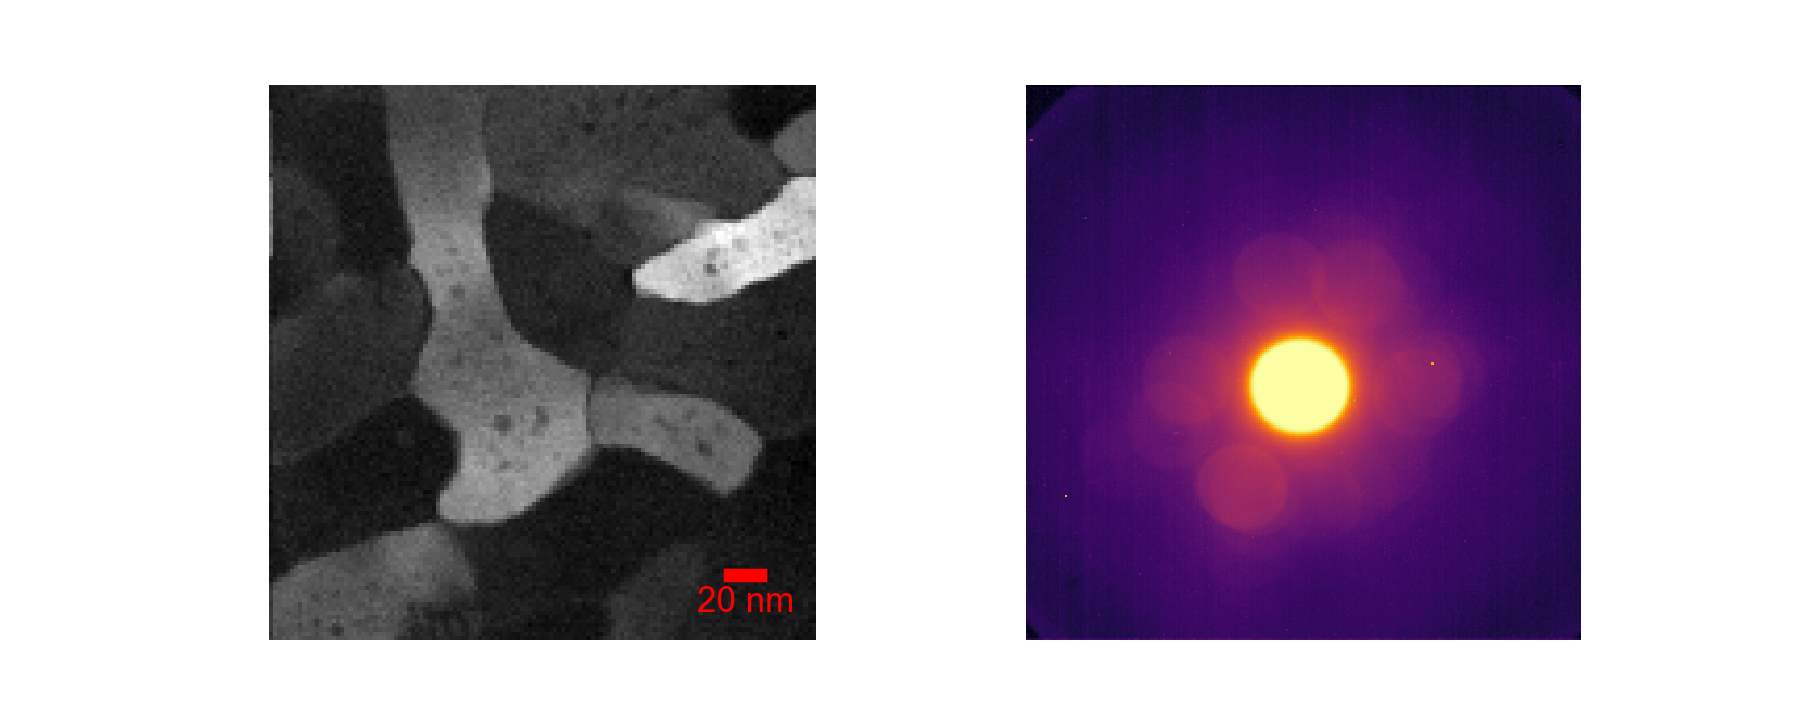

In [5]:
#take average diffraction pattern accross whole area
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm


aveDP = np.average(datacube.data, axis=(0,1))

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))

#plot real space image
ax1.matshow(np.average(datacube.data, axis=(2,3)))
fontprops = fm.FontProperties(size=14, family='Arial') #for scale bar

barsize = 1/im0['pixelSize'][0]/256*20
scalebar = AnchoredSizeBar(transform=ax1.transAxes, size=barsize, label='20 nm', loc=4, 
                           borderpad=0.5,
                           color='red',
                           size_vertical=0.02, frameon=False,
                           fontproperties=fontprops)
ax1.add_artist(scalebar)

#plot sqrt of average diffraciton pattern 
ax2.matshow(np.sqrt(aveDP), cmap=plt.cm.inferno)

ax1.axis('off')
ax2.axis('off')

plt.show()

In [6]:
#find center of diffraction pattern

from skued.image import powder_center
ic, jc = powder_center(aveDP)
print("ic is " + str(ic))
print("jc is " + str(jc))
#expected about (125,138) for (x,y), somehow powder center switched x and y so keep that in mind for the future  

ic is 138.5
jc is 126.0


<IPython.core.display.Javascript object>


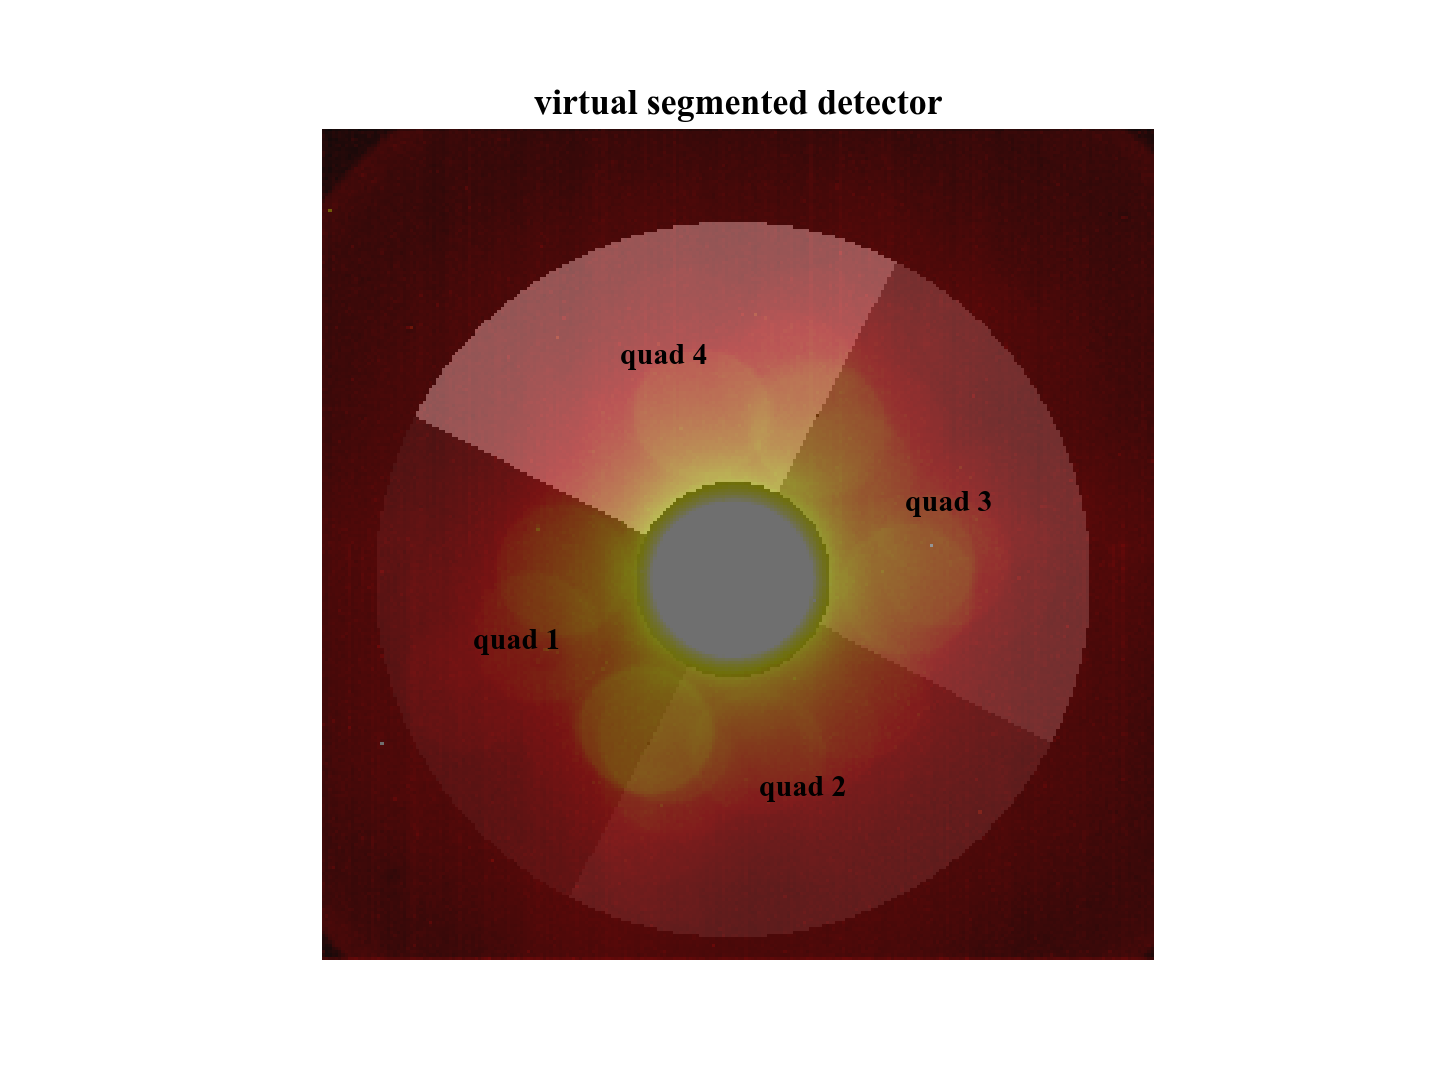

number of elements in mask1 is 8794
number of elements in mask2 is 8797
number of elements in mask3 is 8794
number of elements in mask4 is 8797


In [7]:
from scipy import ndimage
plt.rc('font', family='serif', serif='Times New Roman', size= 12)

#make a quadrant mask defined by circle centered at origin of diffraciton (ic,jc)
xa, ya = 100, 189

#rotate point by 90° relative to ic, jc (going to use point-point form to define lines for masks)
theta = np.radians(90)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))

v=np.array([[xa-jc],[ya-ic]])
v=np.dot(v.T,R).T
xb=v[0,0]+jc
yb=v[1,0]+ic

#create masks changing inequalities
x, y = np.indices((aveDP.shape[0], aveDP.shape[1]))
mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 110 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 30 ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) < 0
mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) < 0
mask1 = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask1_COM=ndimage.measurements.center_of_mass(mask1)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 110 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 30 ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) > 0
mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) < 0
mask2 = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask2_COM=ndimage.measurements.center_of_mass(mask2)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 110 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 30 ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) > 0
mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) > 0
mask3 = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask3_COM=ndimage.measurements.center_of_mass(mask3)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 110 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 30 ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) < 0
mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) > 0
mask4 = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask4_COM=ndimage.measurements.center_of_mass(mask4)

#plot masks
fig,ax = plt.subplots(figsize=(8,6))
ax.imshow(mask1, alpha=0.5)
ax.text(mask1_COM[1],mask1_COM[0],'quad 1', ha='center')
ax.imshow(mask2, alpha=0.5)
ax.text(mask2_COM[1],mask2_COM[0],'quad 2', ha='center')
ax.imshow(mask3, alpha=0.5)
ax.text(mask3_COM[1],mask3_COM[0],'quad 3', ha='center')
ax.imshow(mask4, alpha=0.5)
ax.text(mask4_COM[1],mask4_COM[0],'quad 4', ha='center')
ax.imshow(np.sqrt(aveDP), cmap=plt.cm.hot, alpha=0.4, vmax=12, )
ax.set_title('virtual segmented detector')
ax.axis('off')
plt.show()

#check they are of equal area
print('number of elements in mask1 is ' + str(mask1.sum()))
print('number of elements in mask2 is ' + str(mask2.sum()))
print('number of elements in mask3 is ' + str(mask3.sum()))
print('number of elements in mask4 is ' + str(mask4.sum()))

In [8]:
int_mask1=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))
int_mask2=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))
int_mask3=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))
int_mask4=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))

for i in range(0,aveDP.shape[0]):
    for j in range(0,aveDP.shape[1]): 
            if mask1[i,j]:
                int_mask1=int_mask1+datacube.data[:,:,i,j] 
            if mask2[i,j]:
                int_mask2=int_mask2+datacube.data[:,:,i,j] 
            if mask3[i,j]:
                int_mask3=int_mask3+datacube.data[:,:,i,j] 
            if mask4[i,j]:
                int_mask4=int_mask4+datacube.data[:,:,i,j] 

<IPython.core.display.Javascript object>


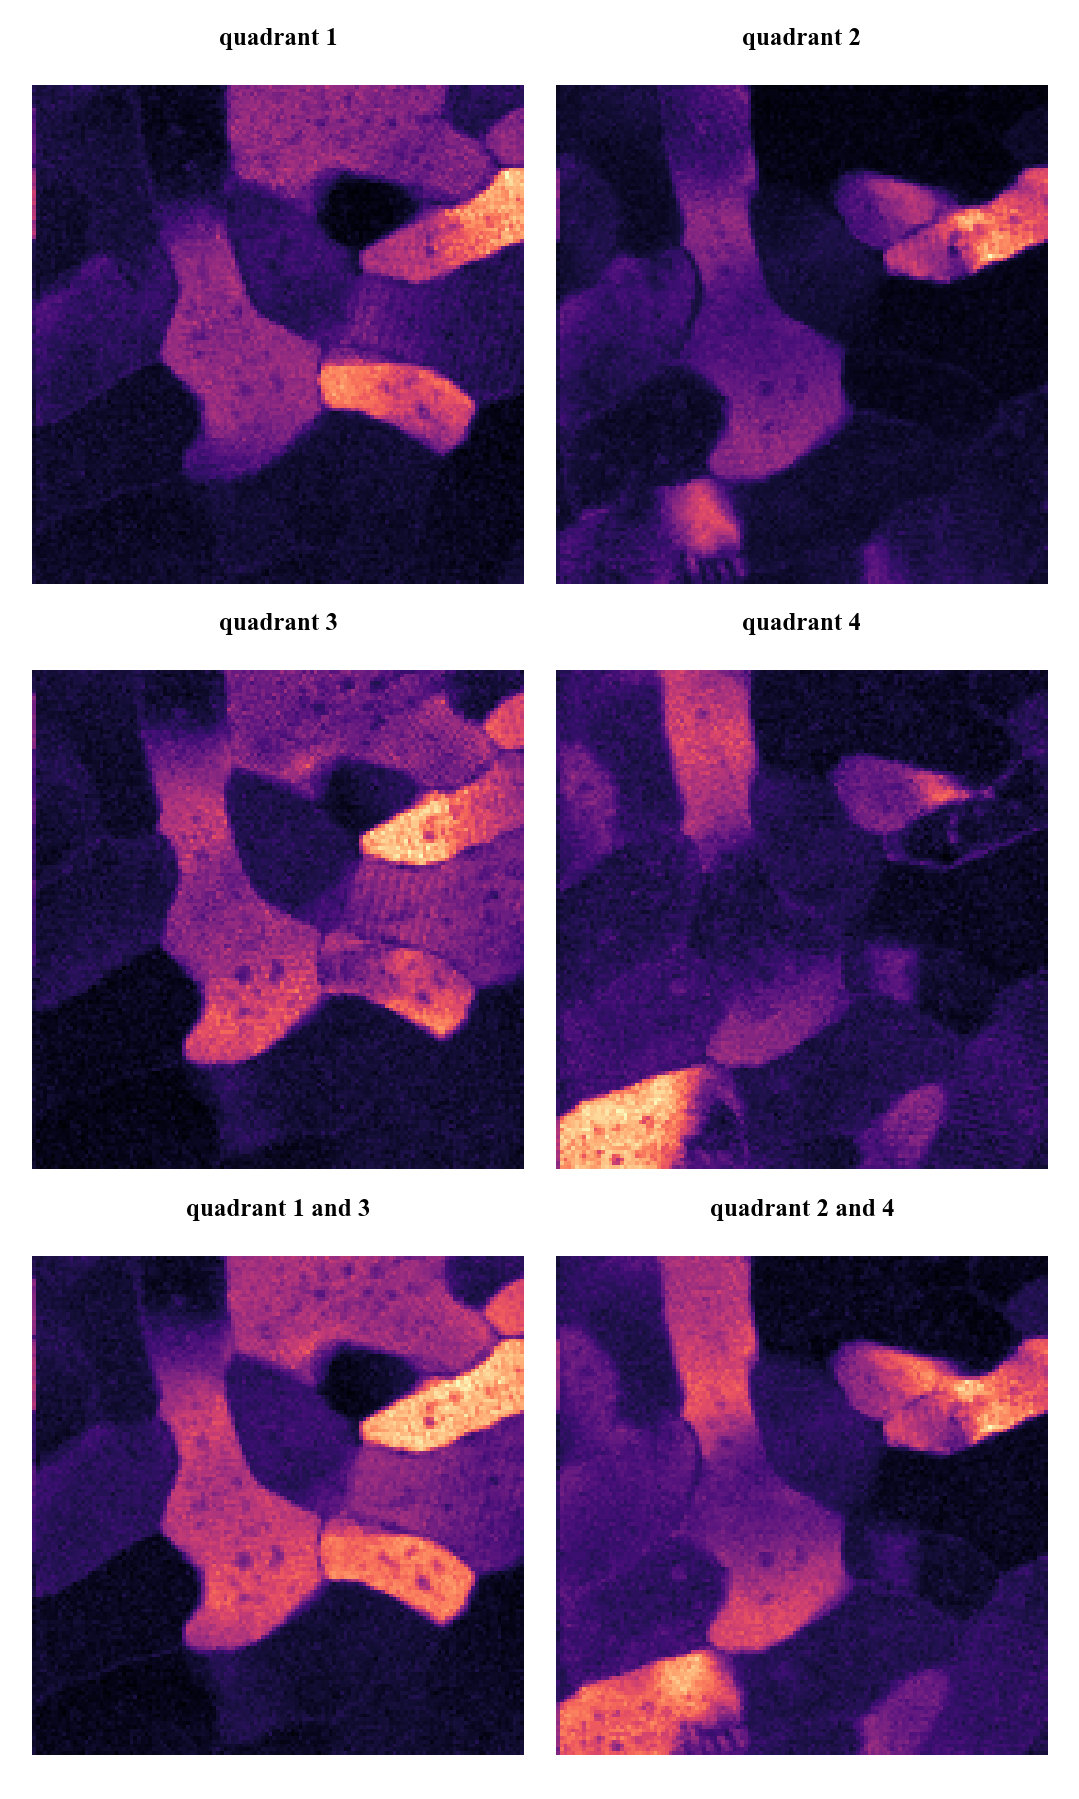

In [9]:
fig, ax = plt.subplots(3,2, figsize=(6,10))
ax[0,0].matshow(int_mask1, cmap=plt.cm.magma)
ax[0,1].matshow(int_mask2, cmap=plt.cm.magma)
ax[1,0].matshow(int_mask3, cmap=plt.cm.magma)
ax[1,1].matshow(int_mask4, cmap=plt.cm.magma)
ax[2,0].matshow(int_mask3+int_mask1, cmap=plt.cm.magma)
ax[2,1].matshow(int_mask4+int_mask2, cmap=plt.cm.magma)


ax[2,0].axis('off')
ax[2,1].axis('off')
ax[2,0].set_title('quadrant 1 and 3', size=10)
ax[2,1].set_title('quadrant 2 and 4', size=10)

list1=[1,2,3,4]

for ax, num in zip(ax.flatten(), list1):
    ax.axis('off')
    ax.set_title('quadrant ' + str(num), size=10)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


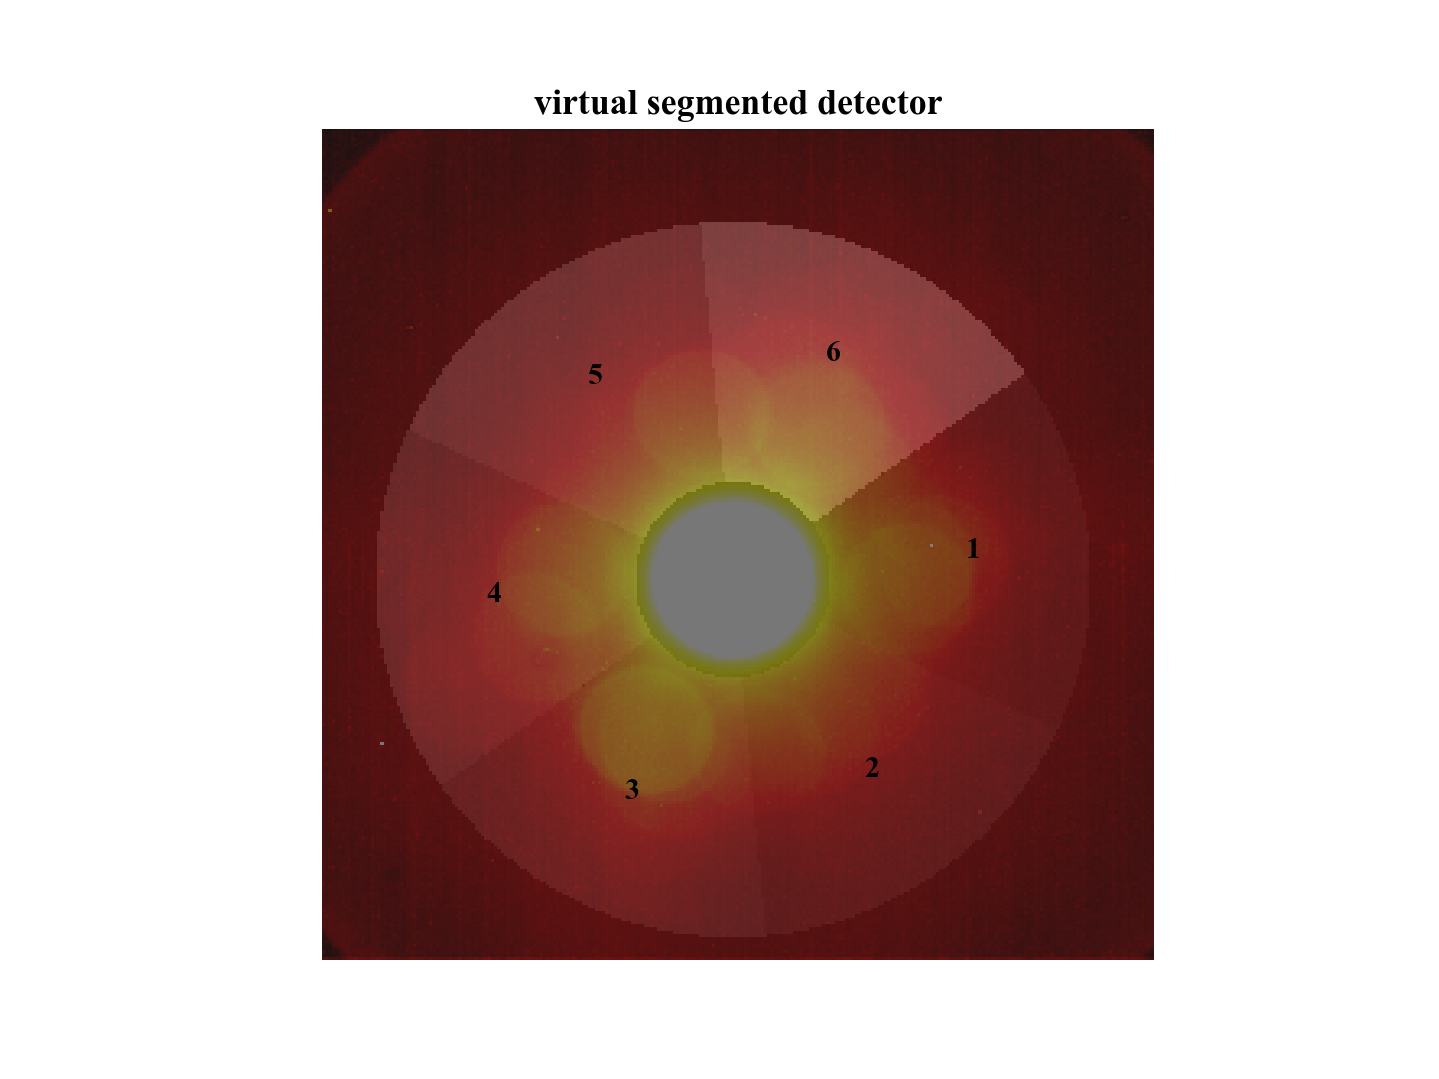

number of elements in mask1 is 5864
number of elements in mask2 is 5861
number of elements in mask3 is 5866
number of elements in mask4 is 5864
number of elements in mask5 is 5861
number of elements in mask6 is 5866


In [10]:
#make a quadrant mask defined by circle centered at origin of diffraciton (ic,jc)
xa, ya = 80, 171

#rotate point by 60° relative to ic, jc (going to use point-point form to define lines for masks)
theta = np.radians(60)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))

v=np.array([[xa-jc],[ya-ic]])
v=np.dot(v.T,R).T
xb=v[0,0]+jc
yb=v[1,0]+ic

v=np.dot(v.T,R).T
xc=v[0,0]+jc
yc=v[1,0]+ic

#create masks changing inequalities
x, y = np.indices((aveDP.shape[0], aveDP.shape[1]))
mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 110 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 30 ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) > 0
mask_line_perpendicular =  y - xc - (jc-xc)/(ic-yc) * (x-yc) > 0
mask1_6 = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask1_COM_6=ndimage.measurements.center_of_mass(mask1_6)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 110 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 30 ** 2
mask_line =  y - xb - (jc-xb)/(ic-yb) * (x-yb) > 0
mask_line_perpendicular =  y - xc - (jc-xc)/(ic-yc) * (x-yc) < 0
mask2_6 = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask2_COM_6=ndimage.measurements.center_of_mass(mask2_6)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 110 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 30 ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) > 0
mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) < 0
mask3_6 = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask3_COM_6=ndimage.measurements.center_of_mass(mask3_6)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 110 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 30 ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) < 0
mask_line_perpendicular =  y - xc - (jc-xc)/(ic-yc) * (x-yc) < 0
mask4_6 = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask4_COM_6=ndimage.measurements.center_of_mass(mask4_6)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 110 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 30 ** 2
mask_line =  y - xc - (jc-xc)/(ic-yc) * (x-yc) > 0
mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) < 0
mask5_6 = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask5_COM_6=ndimage.measurements.center_of_mass(mask5_6)


mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 110 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 30 ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) < 0
mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) > 0
mask6_6 = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask6_COM_6=ndimage.measurements.center_of_mass(mask6_6)


#plot masks
fig,ax = plt.subplots(figsize=(8,6))
ax.imshow(mask1_6, alpha=0.3)
ax.text(mask1_COM_6[1],mask1_COM_6[0], '1', ha='center')
ax.imshow(mask2_6, alpha=0.3)
ax.text(mask2_COM_6[1],mask2_COM_6[0],'2', ha='center')
ax.imshow(mask3_6, alpha=0.3)
ax.text(mask3_COM_6[1],mask3_COM_6[0],'3', ha='center')
ax.imshow(mask4_6, alpha=0.3)
ax.text(mask4_COM_6[1],mask4_COM_6[0],'4', ha='center')
ax.imshow(mask5_6, alpha=0.3)
ax.text(mask5_COM_6[1],mask5_COM_6[0],'5', ha='center')
ax.imshow(mask6_6, alpha=0.3)
ax.text(mask6_COM_6[1],mask6_COM_6[0],'6', ha='center')
ax.imshow(np.sqrt(aveDP), cmap=plt.cm.hot, alpha=0.4, vmax=12, )
ax.set_title('virtual segmented detector')
ax.axis('off')
plt.show()

#check they are of equal area
print('number of elements in mask1 is ' + str(mask1_6.sum()))
print('number of elements in mask2 is ' + str(mask2_6.sum()))
print('number of elements in mask3 is ' + str(mask3_6.sum()))
print('number of elements in mask4 is ' + str(mask4_6.sum()))
print('number of elements in mask5 is ' + str(mask5_6.sum()))
print('number of elements in mask6 is ' + str(mask6_6.sum()))

In [11]:
int_mask1_6=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))
int_mask2_6=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))
int_mask3_6=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))
int_mask4_6=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))
int_mask5_6=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))
int_mask6_6=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))

for i in range(0,aveDP.shape[0]):
    for j in range(0,aveDP.shape[1]): 
            if mask1_6[i,j]:
                int_mask1_6=int_mask1_6+datacube.data[:,:,i,j] 
            if mask2_6[i,j]:
                int_mask2_6=int_mask2_6+datacube.data[:,:,i,j] 
            if mask3_6[i,j]:
                int_mask3_6=int_mask3_6+datacube.data[:,:,i,j] 
            if mask4_6[i,j]:
                int_mask4_6=int_mask4_6+datacube.data[:,:,i,j] 
            if mask5_6[i,j]:
                int_mask5_6=int_mask5_6+datacube.data[:,:,i,j] 
            if mask6_6[i,j]:
                int_mask6_6=int_mask6_6+datacube.data[:,:,i,j] 

In [12]:
print(np.min(int_mask1_6))
print(np.min(int_mask2_6))
print(np.min(int_mask3_6))
print(np.min(int_mask4_6))
print(np.min(int_mask5_6))
print(np.min(int_mask6_6))

143450.0
133321.0
129946.0
144017.0
131228.0
140260.0


In [68]:
print(np.min(int_mask5_6+int_mask3_6+int_mask1_6))
print(np.min(int_mask6_6+int_mask4_6+int_mask2_6))

453026.0
474573.0


<IPython.core.display.Javascript object>


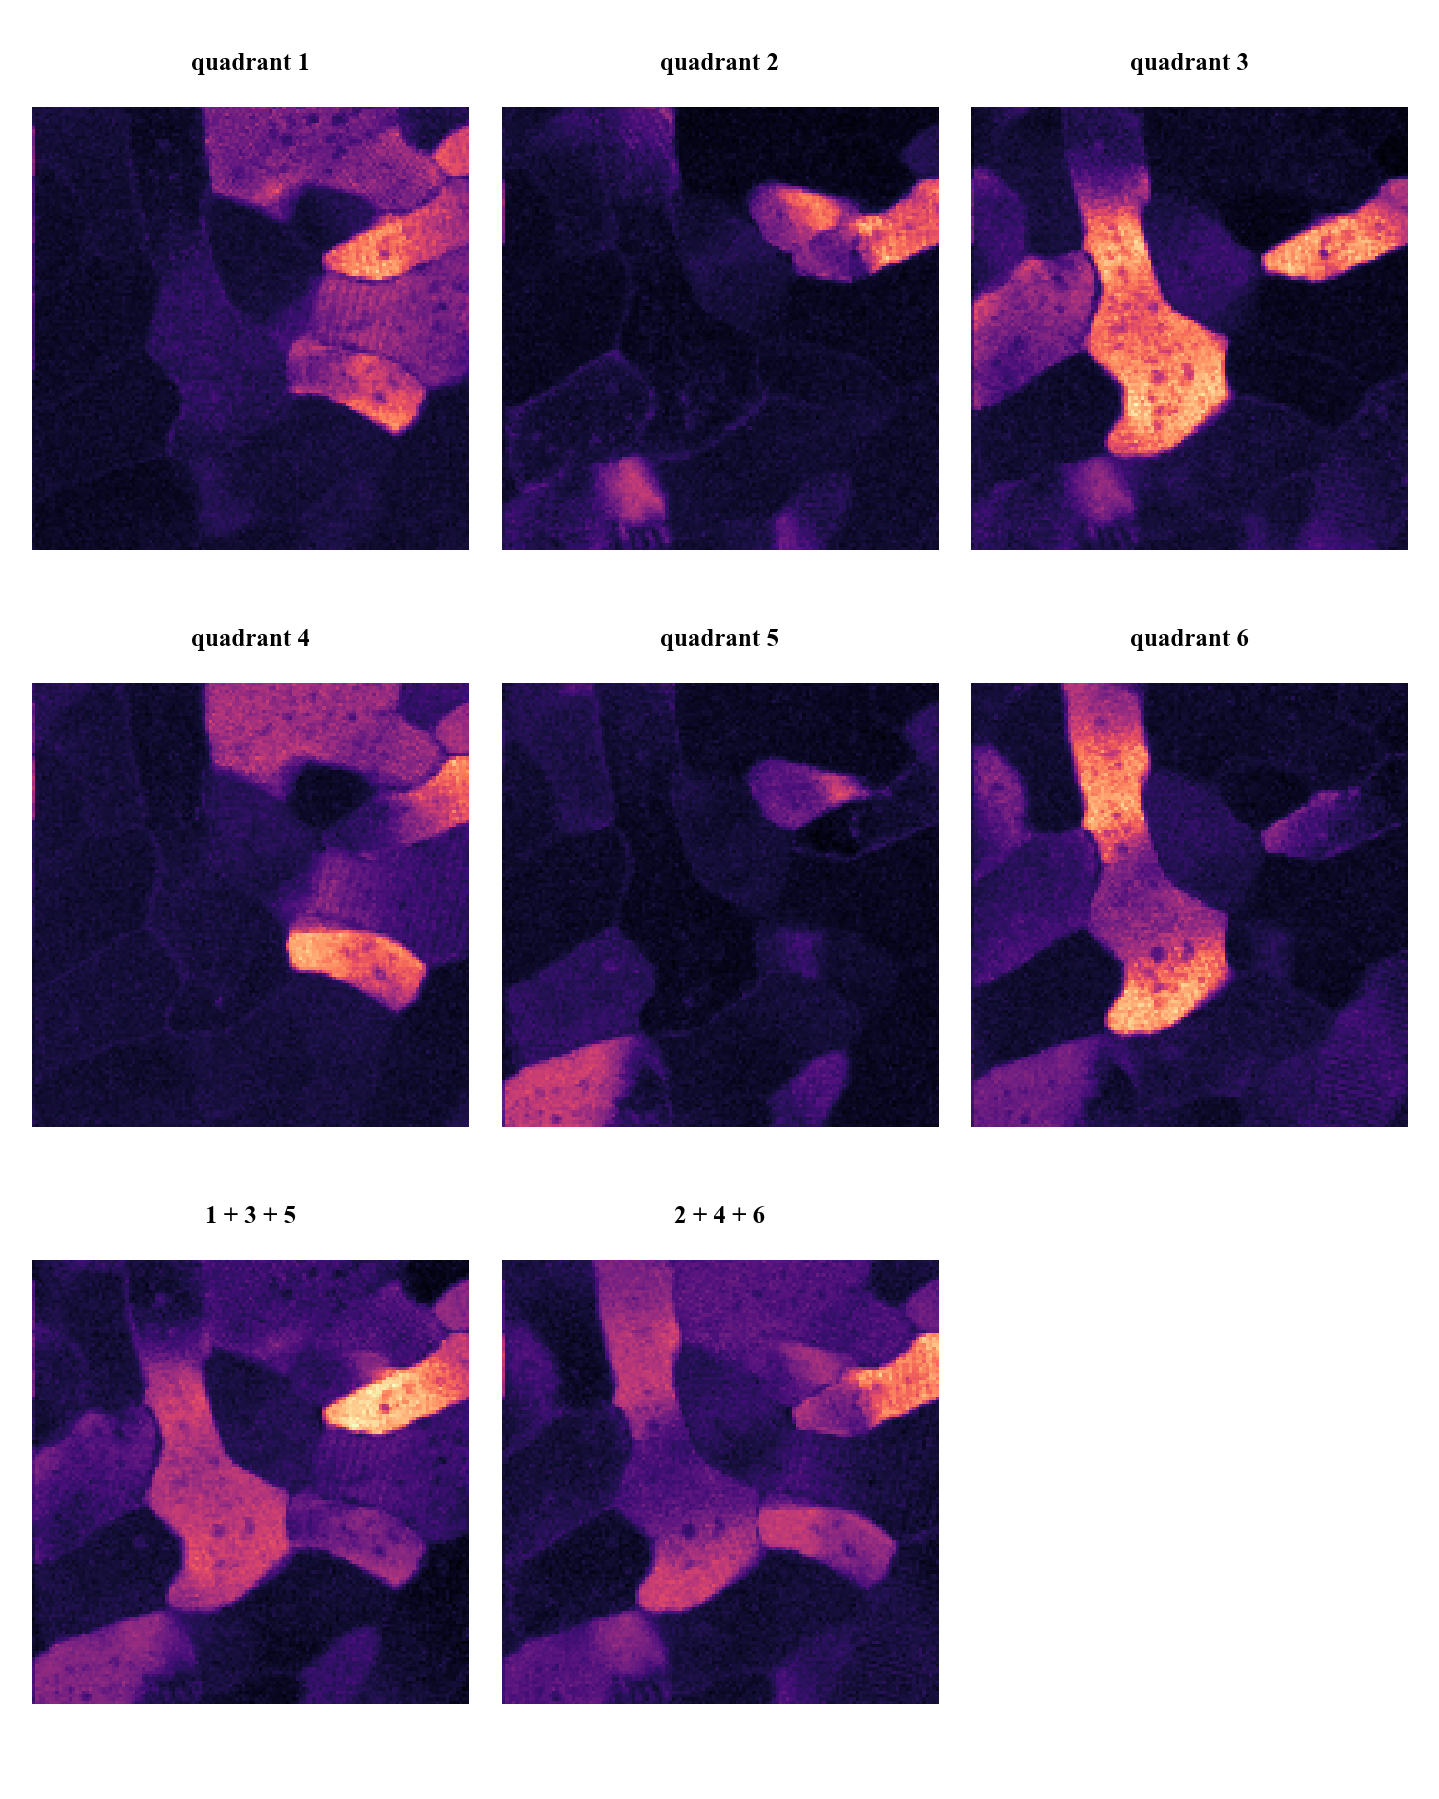

In [13]:
fig, ax = plt.subplots(3,3, figsize=(8,10))
ax[0,0].matshow(int_mask1_6, cmap=plt.cm.magma, vmax=532139, vmin=129946)
ax[0,1].matshow(int_mask2_6, cmap=plt.cm.magma, vmax=532139, vmin=129946)
ax[0,2].matshow(int_mask3_6, cmap=plt.cm.magma, vmax=532139, vmin=129946)
ax[1,0].matshow(int_mask4_6, cmap=plt.cm.magma, vmax=532139, vmin=129946)
ax[1,1].matshow(int_mask5_6, cmap=plt.cm.magma, vmax=532139, vmin=129946)
ax[1,2].matshow(int_mask6_6, cmap=plt.cm.magma, vmax=532139, vmin=129946)
ax[2,0].matshow(int_mask5_6+int_mask3_6+int_mask1_6, cmap=plt.cm.magma, vmax=1086646, vmin=453026)
ax[2,1].matshow(int_mask6_6+int_mask4_6+int_mask2_6, cmap=plt.cm.magma, vmax=1086646, vmin=453026)


ax[2,0].axis('off')
ax[2,1].axis('off')
ax[2,2].axis('off')
ax[2,0].set_title('1 + 3 + 5', size=10)
ax[2,1].set_title('2 + 4 + 6', size=10)

list1=[1,2,3,4,5,6]

for ax, num in zip(ax.flatten(), list1):
    ax.axis('off')
    ax.set_title('quadrant ' + str(num), size=10)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


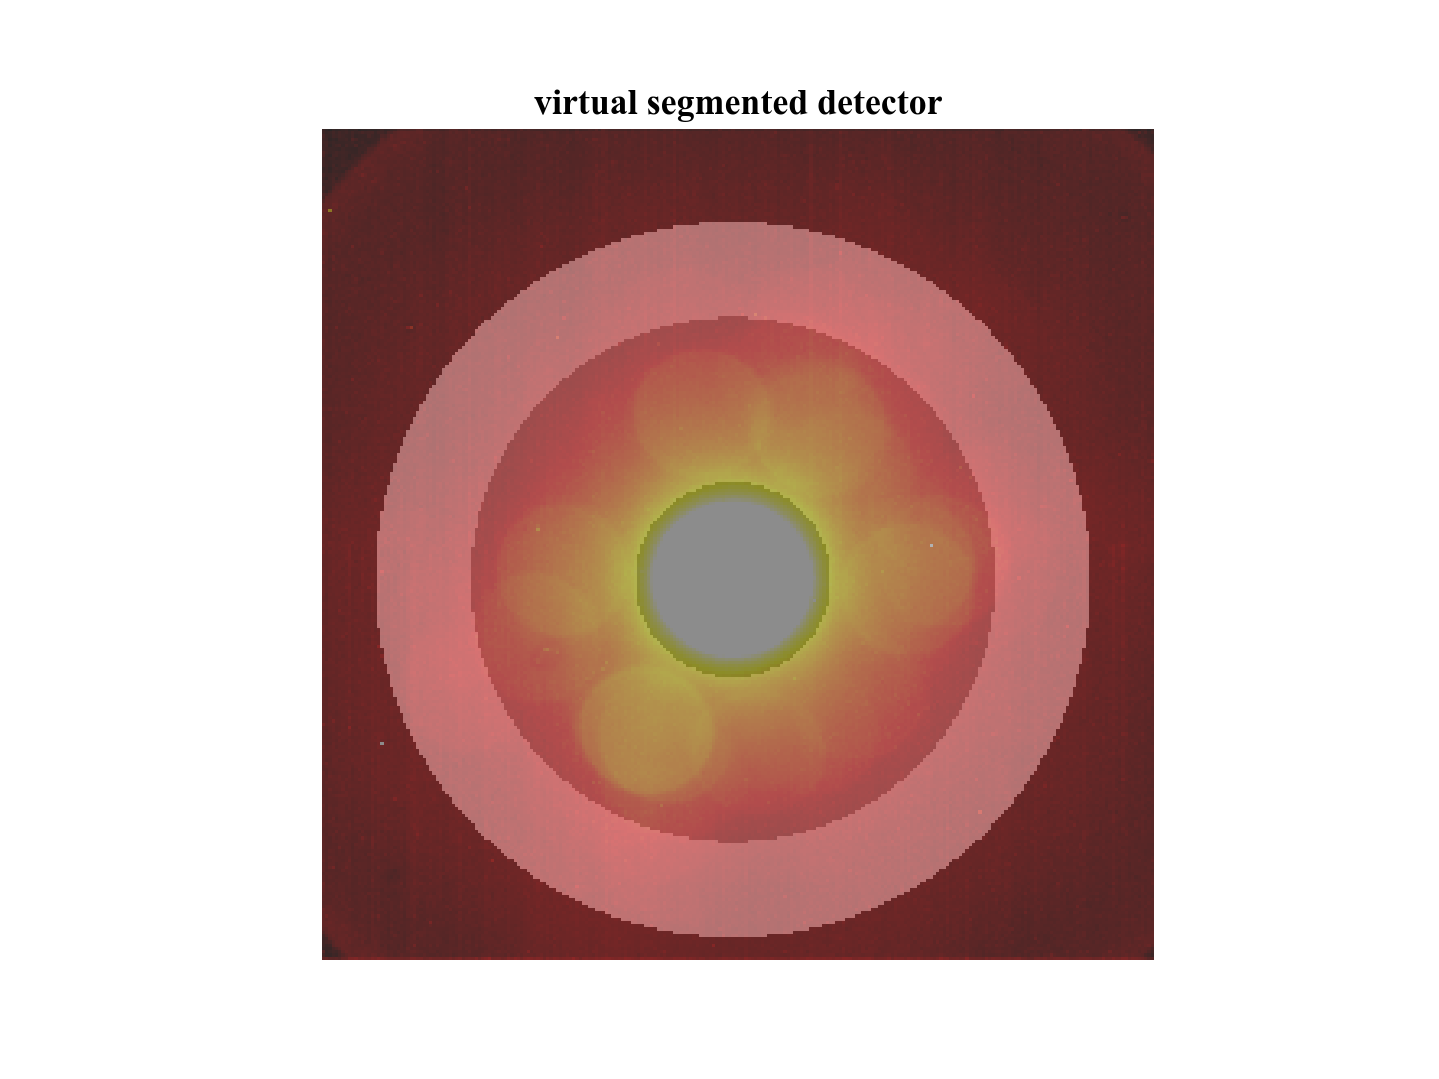

number of elements in mask1 is 17618
number of elements in mask2 is 17566


In [14]:
pixel_rad=53.770;

#create masks changing inequalities
x, y = np.indices((aveDP.shape[0], aveDP.shape[1]))

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < (pixel_rad*1.5) ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 30 ** 2
mask1_circle = np.logical_and(mask_circle, mask_circle2)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 110 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > (pixel_rad*1.5) ** 2
mask2_circle = np.logical_and(mask_circle, mask_circle2)

#plot masks
fig,ax = plt.subplots(figsize=(8,6))
ax.imshow(mask1_circle, alpha=0.5)
ax.imshow(mask2_circle, alpha=0.5)
ax.imshow(np.sqrt(aveDP), cmap=plt.cm.hot, alpha=0.4, vmax=12, )
ax.set_title('virtual segmented detector')
ax.axis('off')
plt.show()

#check they are of equal area
print('number of elements in mask1 is ' + str(mask1_circle.sum()))
print('number of elements in mask2 is ' + str(mask2_circle.sum()))

In [15]:
int_mask1_circle=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))
int_mask2_circle=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))

for i in range(0,aveDP.shape[0]):
    for j in range(0,aveDP.shape[1]): 
            if mask1_circle[i,j]:
                int_mask1_circle=int_mask1_circle+datacube.data[:,:,i,j] 
            if mask2_circle[i,j]:
                int_mask2_circle=int_mask2_circle+datacube.data[:,:,i,j] 

<IPython.core.display.Javascript object>


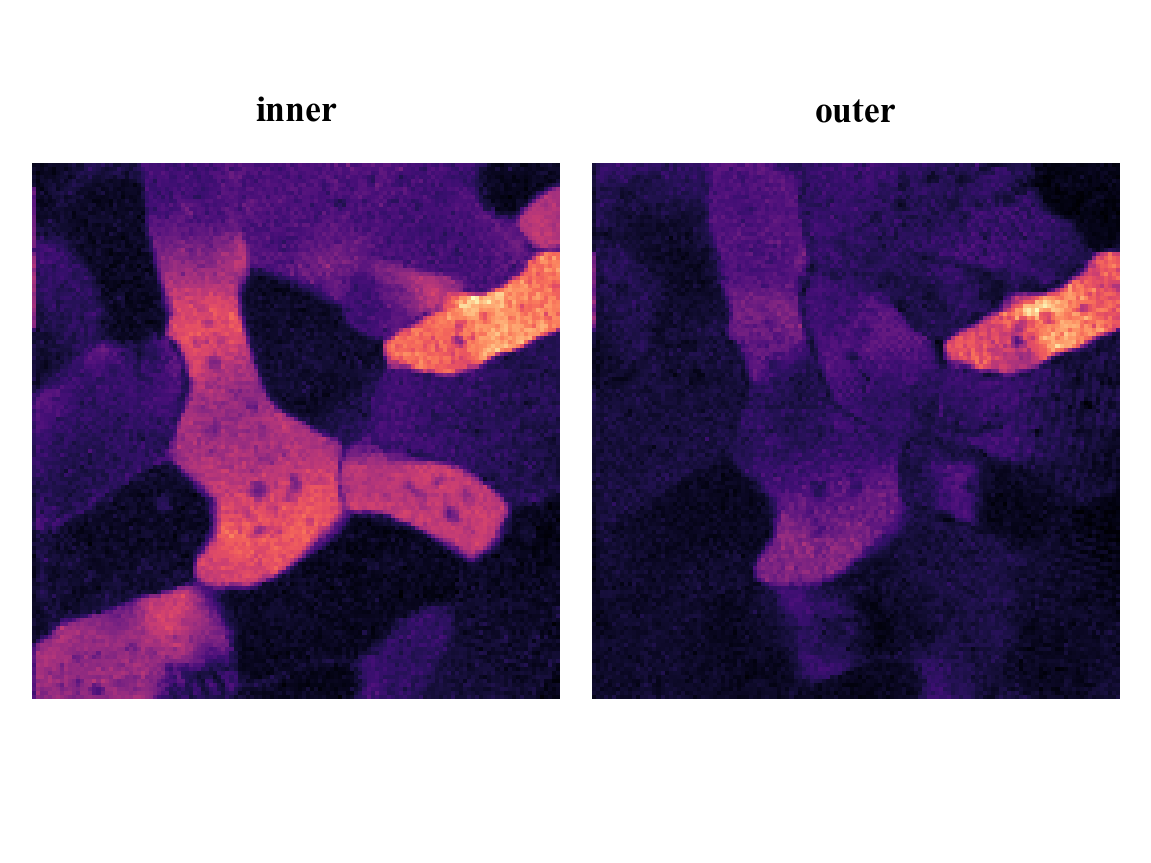

In [16]:
fig, ax = plt.subplots(1,2)
ax[0].matshow(int_mask1_circle, cmap=plt.cm.magma)
ax[1].matshow(int_mask2_circle, cmap=plt.cm.magma)
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('inner')
ax[1].set_title('outer')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


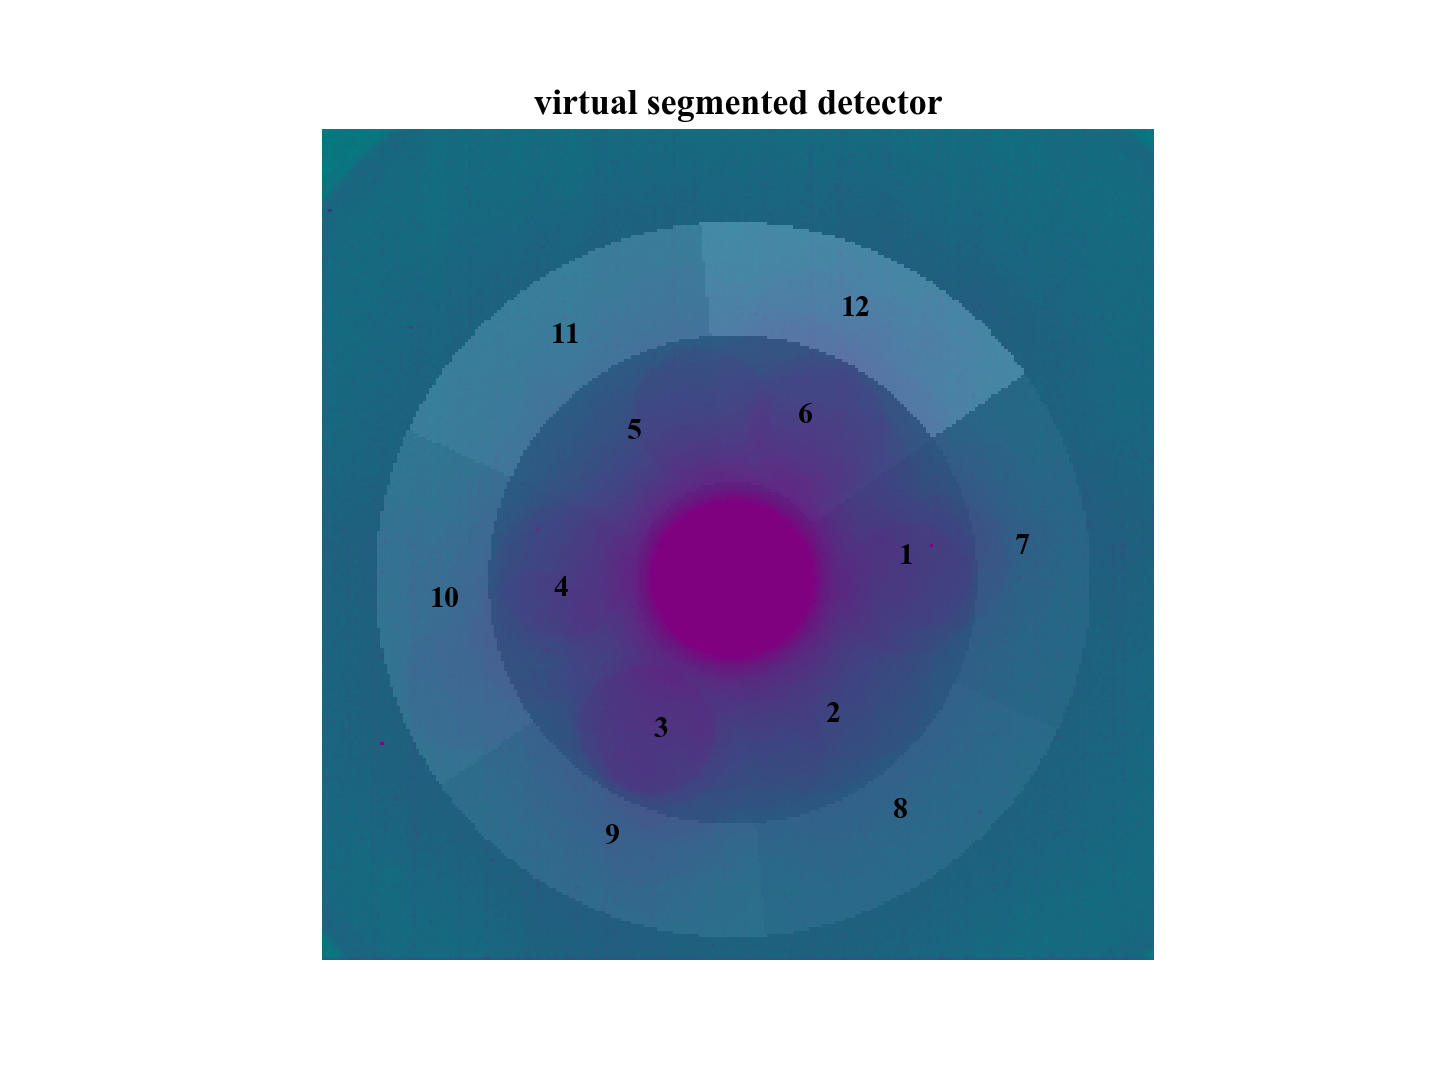

number of elements in mask1 is 2498
number of elements in mask2 is 2494
number of elements in mask3 is 2492
number of elements in mask4 is 2498
number of elements in mask5 is 2494
number of elements in mask6 is 2492
number of elements in mask7 is 3366
number of elements in mask8 is 3367
number of elements in mask9 is 3374
number of elements in mask10 is 3366
number of elements in mask11 is 3367
number of elements in mask12 is 3374


In [17]:
#make a quadrant mask defined by circle centered at origin of diffraciton (ic,jc)

xa, ya = 80, 171

dividing_rad=pixel_rad*1.4

#rotate point by 60° relative to ic, jc (going to use point-point form to define lines for masks)
theta = np.radians(60)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))

v=np.array([[xa-jc],[ya-ic]])
v=np.dot(v.T,R).T
xb=v[0,0]+jc
yb=v[1,0]+ic

v=np.dot(v.T,R).T
xc=v[0,0]+jc
yc=v[1,0]+ic

#create masks changing inequalities
x, y = np.indices((aveDP.shape[0], aveDP.shape[1]))
mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < dividing_rad ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 30 ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) > 0
mask_line_perpendicular =  y - xc - (jc-xc)/(ic-yc) * (x-yc) > 0
mask1_6_inner = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask1_COM_6_inner=ndimage.measurements.center_of_mass(mask1_6_inner)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < dividing_rad ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 30 ** 2
mask_line =  y - xb - (jc-xb)/(ic-yb) * (x-yb) > 0
mask_line_perpendicular =  y - xc - (jc-xc)/(ic-yc) * (x-yc) < 0
mask2_6_inner = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask2_COM_6_inner=ndimage.measurements.center_of_mass(mask2_6_inner)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < dividing_rad ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 30 ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) > 0
mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) < 0
mask3_6_inner = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask3_COM_6_inner=ndimage.measurements.center_of_mass(mask3_6_inner)


mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < dividing_rad ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 30 ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) < 0
mask_line_perpendicular =  y - xc - (jc-xc)/(ic-yc) * (x-yc) < 0
mask4_6_inner = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask4_COM_6_inner=ndimage.measurements.center_of_mass(mask4_6_inner)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < dividing_rad ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 30 ** 2
mask_line =  y - xc - (jc-xc)/(ic-yc) * (x-yc) > 0
mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) < 0
mask5_6_inner = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask5_COM_6_inner=ndimage.measurements.center_of_mass(mask5_6_inner)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < dividing_rad ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 30 ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) < 0
mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) > 0
mask6_6_inner = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask6_COM_6_inner=ndimage.measurements.center_of_mass(mask6_6_inner)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 110 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > dividing_rad ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) > 0
mask_line_perpendicular =  y - xc - (jc-xc)/(ic-yc) * (x-yc) > 0
mask1_6_outer= np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask1_COM_6_outer=ndimage.measurements.center_of_mass(mask1_6_outer)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 110 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > dividing_rad ** 2
mask_line =  y - xb - (jc-xb)/(ic-yb) * (x-yb) > 0
mask_line_perpendicular =  y - xc - (jc-xc)/(ic-yc) * (x-yc) < 0
mask2_6_outer = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask2_COM_6_outer=ndimage.measurements.center_of_mass(mask2_6_outer)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 110 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > dividing_rad ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) > 0
mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) < 0
mask3_6_outer = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask3_COM_6_outer=ndimage.measurements.center_of_mass(mask3_6_outer)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 110 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > dividing_rad ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) < 0
mask_line_perpendicular =  y - xc - (jc-xc)/(ic-yc) * (x-yc) < 0
mask4_6_outer = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask4_COM_6_outer=ndimage.measurements.center_of_mass(mask4_6_outer)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 110 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > dividing_rad ** 2
mask_line =  y - xc - (jc-xc)/(ic-yc) * (x-yc) > 0
mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) < 0
mask5_6_outer = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask5_COM_6_outer=ndimage.measurements.center_of_mass(mask5_6_outer)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 110 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > dividing_rad ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) < 0
mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) > 0
mask6_6_outer = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
mask6_COM_6_outer=ndimage.measurements.center_of_mass(mask6_6_outer)

#plot masks
fig,ax = plt.subplots(figsize=(8,6))
ax.imshow(mask1_6_inner, alpha=0.3)
ax.text(mask1_COM_6_inner[1],mask1_COM_6_inner[0], '1', ha='center')
ax.imshow(mask2_6_inner, alpha=0.3)
ax.text(mask2_COM_6_inner[1],mask2_COM_6_inner[0],'2', ha='center')
ax.imshow(mask3_6_inner, alpha=0.3)
ax.text(mask3_COM_6_inner[1],mask3_COM_6_inner[0],'3', ha='center')
ax.imshow(mask4_6_inner, alpha=0.3)
ax.text(mask4_COM_6_inner[1],mask4_COM_6_inner[0],'4', ha='center')
ax.imshow(mask5_6_inner, alpha=0.3)
ax.text(mask5_COM_6_inner[1],mask5_COM_6_inner[0],'5', ha='center')
ax.imshow(mask6_6_inner, alpha=0.3)
ax.text(mask6_COM_6_inner[1],mask6_COM_6_inner[0],'6', ha='center')
ax.imshow(mask1_6_outer, alpha=0.3)
ax.text(mask1_COM_6_outer[1],mask1_COM_6_outer[0], '7', ha='center')
ax.imshow(mask2_6_outer, alpha=0.3)
ax.text(mask2_COM_6_outer[1],mask2_COM_6_outer[0],'8', ha='center')
ax.imshow(mask3_6_outer, alpha=0.3)
ax.text(mask3_COM_6_outer[1],mask3_COM_6_outer[0],'9', ha='center')
ax.imshow(mask4_6_outer, alpha=0.3)
ax.text(mask4_COM_6_outer[1],mask4_COM_6_outer[0],'10', ha='center')
ax.imshow(mask5_6_outer, alpha=0.3)
ax.text(mask5_COM_6_outer[1],mask5_COM_6_outer[0],'11', ha='center')
ax.imshow(mask6_6_outer, alpha=0.3)
ax.text(mask6_COM_6_outer[1],mask6_COM_6_outer[0],'12', ha='center')
ax.imshow(np.sqrt(aveDP), cmap=plt.cm.cool, alpha=0.5, vmax=12, )
ax.set_title('virtual segmented detector')
ax.axis('off')
plt.show()

#check they are of equal area
print('number of elements in mask1 is ' + str(mask1_6_inner.sum()))
print('number of elements in mask2 is ' + str(mask2_6_inner.sum()))
print('number of elements in mask3 is ' + str(mask3_6_inner.sum()))
print('number of elements in mask4 is ' + str(mask4_6_inner.sum()))
print('number of elements in mask5 is ' + str(mask5_6_inner.sum()))
print('number of elements in mask6 is ' + str(mask6_6_inner.sum()))
print('number of elements in mask7 is ' + str(mask1_6_outer.sum()))
print('number of elements in mask8 is ' + str(mask2_6_outer.sum()))
print('number of elements in mask9 is ' + str(mask3_6_outer.sum()))
print('number of elements in mask10 is ' + str(mask4_6_outer.sum()))
print('number of elements in mask11 is ' + str(mask5_6_outer.sum()))
print('number of elements in mask12 is ' + str(mask6_6_outer.sum()))

In [18]:
int_mask1_6_inner=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))
int_mask2_6_inner=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))
int_mask3_6_inner=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))
int_mask4_6_inner=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))
int_mask5_6_inner=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))
int_mask6_6_inner=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))
int_mask1_6_outer=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))
int_mask2_6_outer=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))
int_mask3_6_outer=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))
int_mask4_6_outer=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))
int_mask5_6_outer=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))
int_mask6_6_outer=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))

for i in range(0,aveDP.shape[0]):
    for j in range(0,aveDP.shape[1]): 
            if mask1_6_inner[i,j]:
                int_mask1_6_inner=int_mask1_6_inner+datacube.data[:,:,i,j] 
            if mask2_6[i,j]:
                int_mask2_6_inner=int_mask2_6_inner+datacube.data[:,:,i,j] 
            if mask3_6[i,j]:
                int_mask3_6_inner=int_mask3_6_inner+datacube.data[:,:,i,j] 
            if mask4_6[i,j]:
                int_mask4_6_inner=int_mask4_6_inner+datacube.data[:,:,i,j] 
            if mask5_6[i,j]:
                int_mask5_6_inner=int_mask5_6_inner+datacube.data[:,:,i,j] 
            if mask6_6[i,j]:
                int_mask6_6_inner=int_mask6_6_inner+datacube.data[:,:,i,j] 
            if mask1_6_outer[i,j]:
                int_mask1_6_outer=int_mask1_6_outer+datacube.data[:,:,i,j] 
            if mask2_6[i,j]:
                int_mask2_6_outer=int_mask2_6_outer+datacube.data[:,:,i,j] 
            if mask3_6[i,j]:
                int_mask3_6_outer=int_mask3_6_outer+datacube.data[:,:,i,j] 
            if mask4_6[i,j]:
                int_mask4_6_outer=int_mask4_6_outer+datacube.data[:,:,i,j] 
            if mask5_6[i,j]:
                int_mask5_6_outer=int_mask5_6_outer+datacube.data[:,:,i,j] 
            if mask6_6[i,j]:
                int_mask6_6_outer=int_mask6_6_outer+datacube.data[:,:,i,j] 

In [52]:
print(np.max(int_mask1_6_outer))
print(np.max(int_mask2_6_outer))
print(np.max(int_mask3_6_outer))
print(np.max(int_mask4_6_outer))
print(np.max(int_mask5_6_outer))
print(np.max(int_mask6_6_outer))
print(np.max(int_mask1_6_inner))
print(np.max(int_mask2_6_inner))
print(np.max(int_mask3_6_inner))
print(np.max(int_mask4_6_inner))
print(np.max(int_mask5_6_inner))
print(np.max(int_mask6_6_inner))

211900.0
502929.0
532139.0
494919.0
380441.0
504381.0
362456.0
502929.0
532139.0
494919.0
380441.0
504381.0


In [19]:
print(np.min(int_mask1_6_outer))
print(np.min(int_mask2_6_outer))
print(np.min(int_mask3_6_outer))
print(np.min(int_mask4_6_outer))
print(np.min(int_mask5_6_outer))
print(np.min(int_mask6_6_outer))
print(np.min(int_mask1_6_inner))
print(np.min(int_mask2_6_inner))
print(np.min(int_mask3_6_inner))
print(np.min(int_mask4_6_inner))
print(np.min(int_mask5_6_inner))
print(np.min(int_mask6_6_inner))

56246.0
133321.0
129946.0
144017.0
131228.0
140260.0
79079.0
133321.0
129946.0
144017.0
131228.0
140260.0


<IPython.core.display.Javascript object>


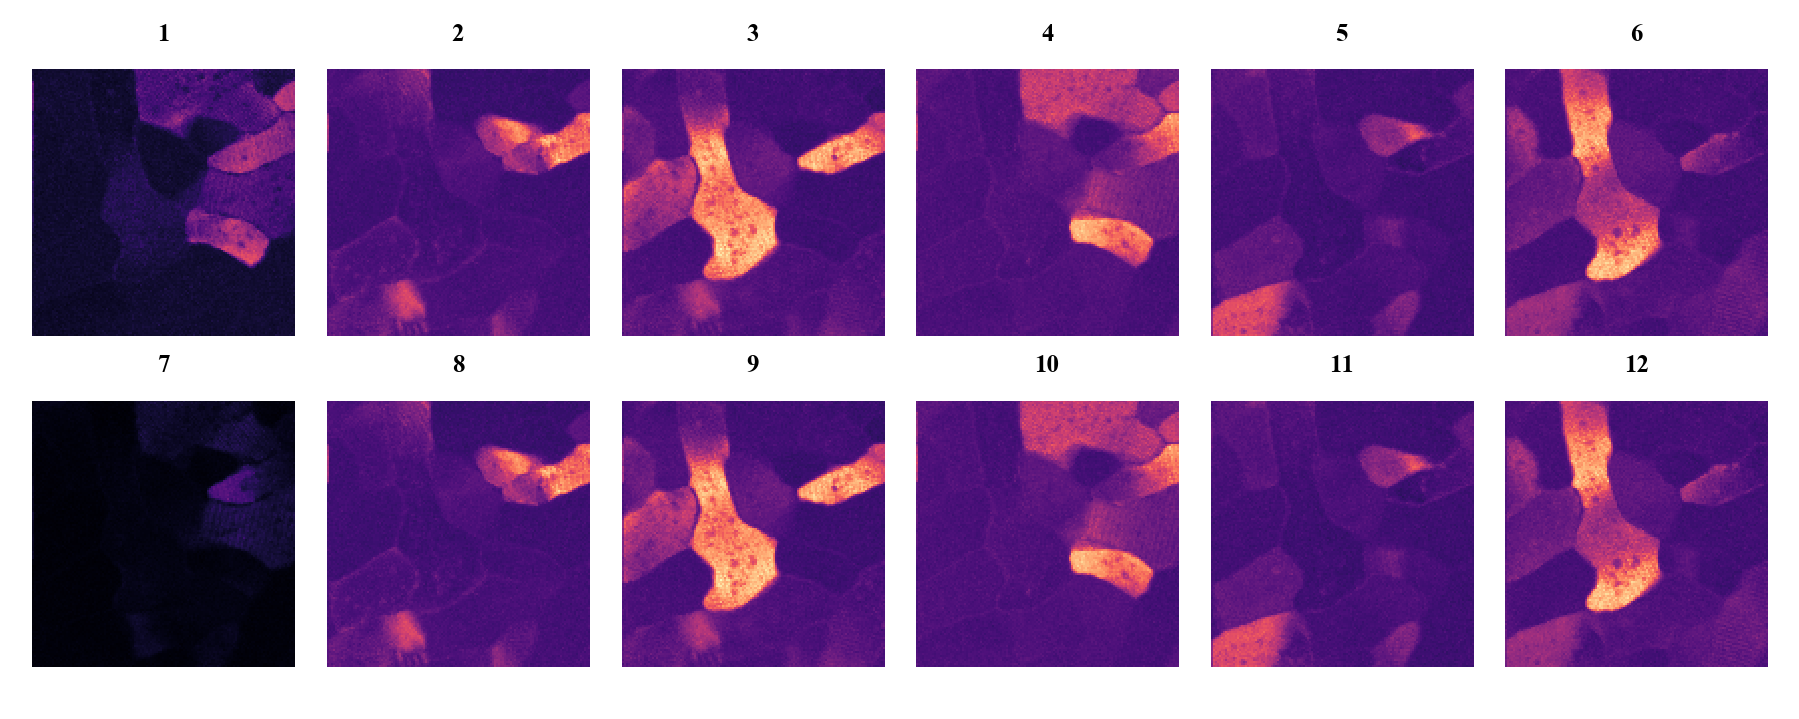

In [57]:
fig, ax = plt.subplots(2,6, figsize=(10,4))
ax[0,0].matshow(int_mask1_6_inner, cmap=plt.cm.magma, vmax=532139, vmin=56246)
ax[0,1].matshow(int_mask2_6_inner, cmap=plt.cm.magma, vmax=532139, vmin=56246)
ax[0,2].matshow(int_mask3_6_inner, cmap=plt.cm.magma, vmax=532139, vmin=56246)
ax[0,3].matshow(int_mask4_6_inner, cmap=plt.cm.magma, vmax=532139, vmin=56246)
ax[0,4].matshow(int_mask5_6_inner, cmap=plt.cm.magma, vmax=532139, vmin=56246)
ax[0,5].matshow(int_mask6_6_inner, cmap=plt.cm.magma, vmax=532139, vmin=56246)

ax[1,0].matshow(int_mask1_6_outer, cmap=plt.cm.magma, vmax=532139, vmin=56246)
ax[1,1].matshow(int_mask2_6_outer, cmap=plt.cm.magma, vmax=532139, vmin=56246)
ax[1,2].matshow(int_mask3_6_outer, cmap=plt.cm.magma, vmax=532139, vmin=56246)
ax[1,3].matshow(int_mask4_6_outer, cmap=plt.cm.magma, vmax=532139, vmin=56246)
ax[1,4].matshow(int_mask5_6_outer, cmap=plt.cm.magma, vmax=532139, vmin=56246)
ax[1,5].matshow(int_mask6_6_outer, cmap=plt.cm.magma, vmax=532139, vmin=56246)

list1=[1,2,3,4,5,6,7,8,9,10,11,12]

for ax, num in zip(ax.flatten(), list1):
    ax.axis('off')
    ax.set_title(str(num), size=10)
plt.tight_layout()
plt.show()

In [20]:
print(np.max(int_mask1_6_inner+int_mask3_6_inner+int_mask5_6_inner))
print(np.max(int_mask2_6_inner+int_mask4_6_inner+int_mask6_6_inner))
print(np.max(int_mask1_6_outer+int_mask3_6_outer+int_mask5_6_outer))
print(np.max(int_mask2_6_outer+int_mask4_6_outer+int_mask6_6_outer))

print(np.min(int_mask1_6_inner+int_mask3_6_inner+int_mask5_6_inner))
print(np.min(int_mask2_6_inner+int_mask4_6_inner+int_mask6_6_inner))
print(np.min(int_mask1_6_outer+int_mask3_6_outer+int_mask5_6_outer))
print(np.min(int_mask2_6_outer+int_mask4_6_outer+int_mask6_6_outer))

932211.0
1029012.0
828452.0
1029012.0
388053.0
474573.0
351773.0
474573.0


<IPython.core.display.Javascript object>


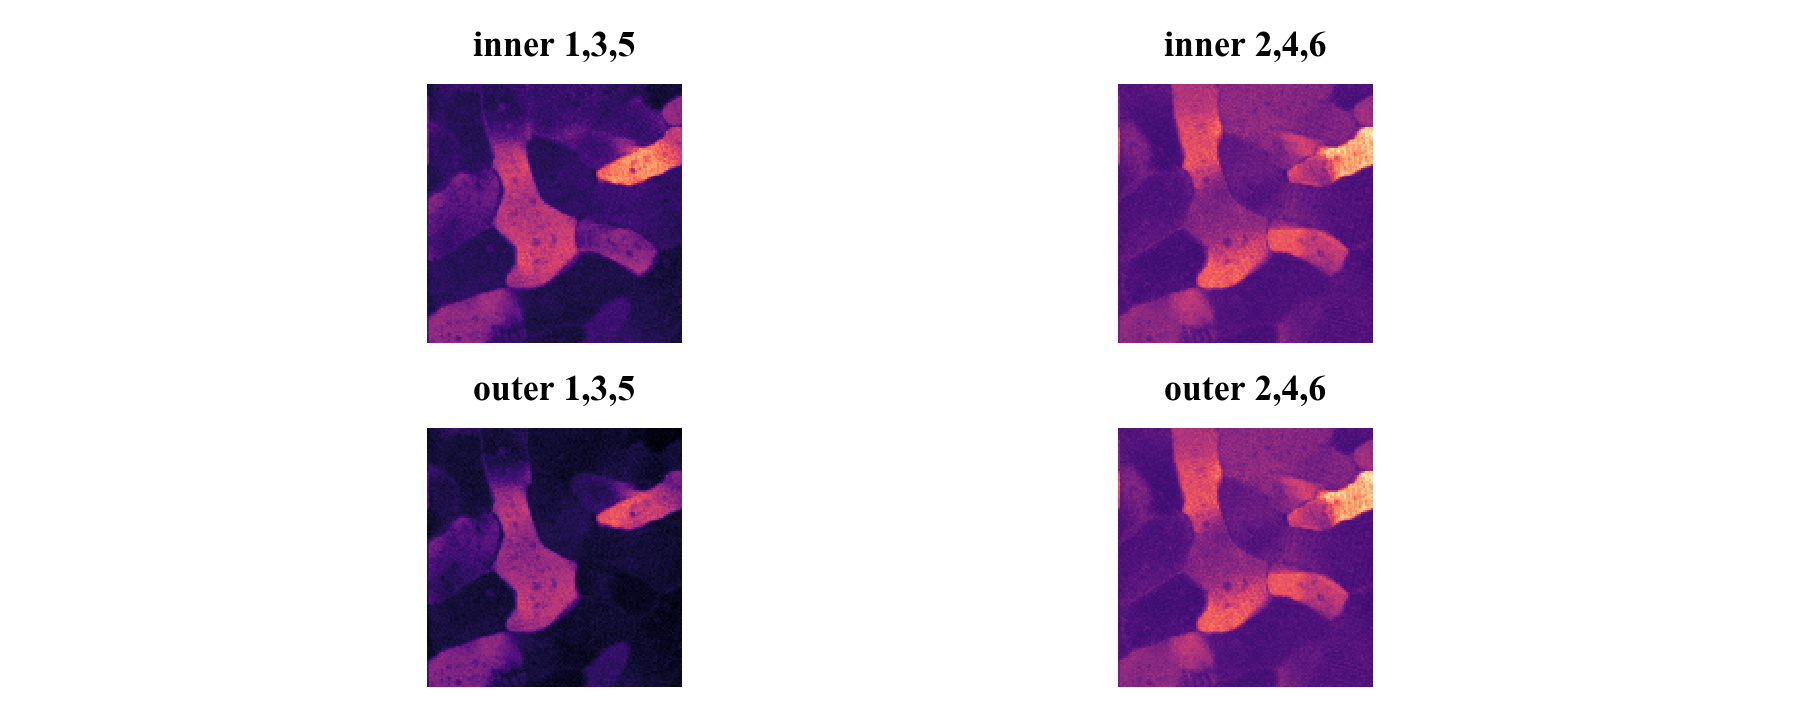

In [21]:
fig, ax = plt.subplots(2,2, figsize=(10,4))
ax[0,0].matshow(int_mask1_6_inner+int_mask3_6_inner+int_mask5_6_inner, cmap=plt.cm.magma, vmax=1029012, vmin=351773)
ax[0,1].matshow(int_mask2_6_inner+int_mask4_6_inner+int_mask6_6_inner, cmap=plt.cm.magma, vmax=1029012, vmin=351773)
ax[0,0].set_title('inner 1,3,5')
ax[0,1].set_title('inner 2,4,6')
ax[1,0].matshow(int_mask1_6_outer+int_mask3_6_outer+int_mask5_6_outer, cmap=plt.cm.magma, vmax=1029012, vmin=351773)
ax[1,1].matshow(int_mask2_6_outer+int_mask4_6_outer+int_mask6_6_outer, cmap=plt.cm.magma, vmax=1029012, vmin=351773)
ax[1,0].set_title('outer 1,3,5')
ax[1,1].set_title('outer 2,4,6')

for ax in ax.flatten():
    ax.axis('off')
plt.tight_layout()
plt.show()

In [22]:
#make a quadrant mask defined by circle centered at origin of diffraciton (ic,jc)

xa, ya = 80, 171

dividing_rad=pixel_rad*1.4

#rotate point by 60° relative to ic, jc (going to use point-point form to define lines for masks)
theta = np.radians(60)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))

v=np.array([[xa-jc],[ya-ic]])
v=np.dot(v.T,R).T
xb=v[0,0]+jc
yb=v[1,0]+ic

v=np.dot(v.T,R).T
xc=v[0,0]+jc
yc=v[1,0]+ic

masks_12=[]

#create masks changing inequalities
x, y = np.indices((aveDP.shape[0], aveDP.shape[1]))
mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < dividing_rad ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 30 ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) > 0
mask_line_perpendicular =  y - xc - (jc-xc)/(ic-yc) * (x-yc) > 0
mask1_6_inner = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
masks_12.append(mask1_6_inner)
    
mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < dividing_rad ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 30 ** 2
mask_line =  y - xb - (jc-xb)/(ic-yb) * (x-yb) > 0
mask_line_perpendicular =  y - xc - (jc-xc)/(ic-yc) * (x-yc) < 0
mask2_6_inner = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
masks_12.append(mask2_6_inner)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < dividing_rad ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 30 ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) > 0
mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) < 0
mask3_6_inner = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
masks_12.append(mask3_6_inner)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < dividing_rad ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 30 ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) < 0
mask_line_perpendicular =  y - xc - (jc-xc)/(ic-yc) * (x-yc) < 0
mask4_6_inner = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
masks_12.append(mask4_6_inner)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < dividing_rad ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 30 ** 2
mask_line =  y - xc - (jc-xc)/(ic-yc) * (x-yc) > 0
mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) < 0
mask5_6_inner = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
masks_12.append(mask5_6_inner)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < dividing_rad ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 30 ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) < 0
mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) > 0
mask6_6_inner = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
masks_12.append(mask6_6_inner)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 110 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > dividing_rad ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) > 0
mask_line_perpendicular =  y - xc - (jc-xc)/(ic-yc) * (x-yc) > 0
mask1_6_outer= np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
masks_12.append(mask1_6_outer)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 110 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > dividing_rad ** 2
mask_line =  y - xb - (jc-xb)/(ic-yb) * (x-yb) > 0
mask_line_perpendicular =  y - xc - (jc-xc)/(ic-yc) * (x-yc) < 0
mask2_6_outer = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
masks_12.append(mask2_6_outer)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 110 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > dividing_rad ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) > 0
mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) < 0
mask3_6_outer = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
masks_12.append(mask3_6_outer)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 110 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > dividing_rad ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) < 0
mask_line_perpendicular =  y - xc - (jc-xc)/(ic-yc) * (x-yc) < 0
mask4_6_outer = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
masks_12.append(mask4_6_outer)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 110 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > dividing_rad ** 2
mask_line =  y - xc - (jc-xc)/(ic-yc) * (x-yc) > 0
mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) < 0
mask5_6_outer = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
masks_12.append(mask5_6_outer)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 110 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > dividing_rad ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) < 0
mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) > 0
mask6_6_outer = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)
masks_12.append(mask6_6_outer)

In [94]:
color_maps=[]
int_mask=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))

for k in range(12):
    int_mask=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))
    for i in range(0,aveDP.shape[0]):
        for j in range(0,aveDP.shape[1]): 
            if masks_12[k][i,j]:
                int_mask=int_mask+datacube.data[:,:,i,j] 
    int_mask=int_mask/masks_12[k].sum()
    color_maps.append(int_mask)

<IPython.core.display.Javascript object>


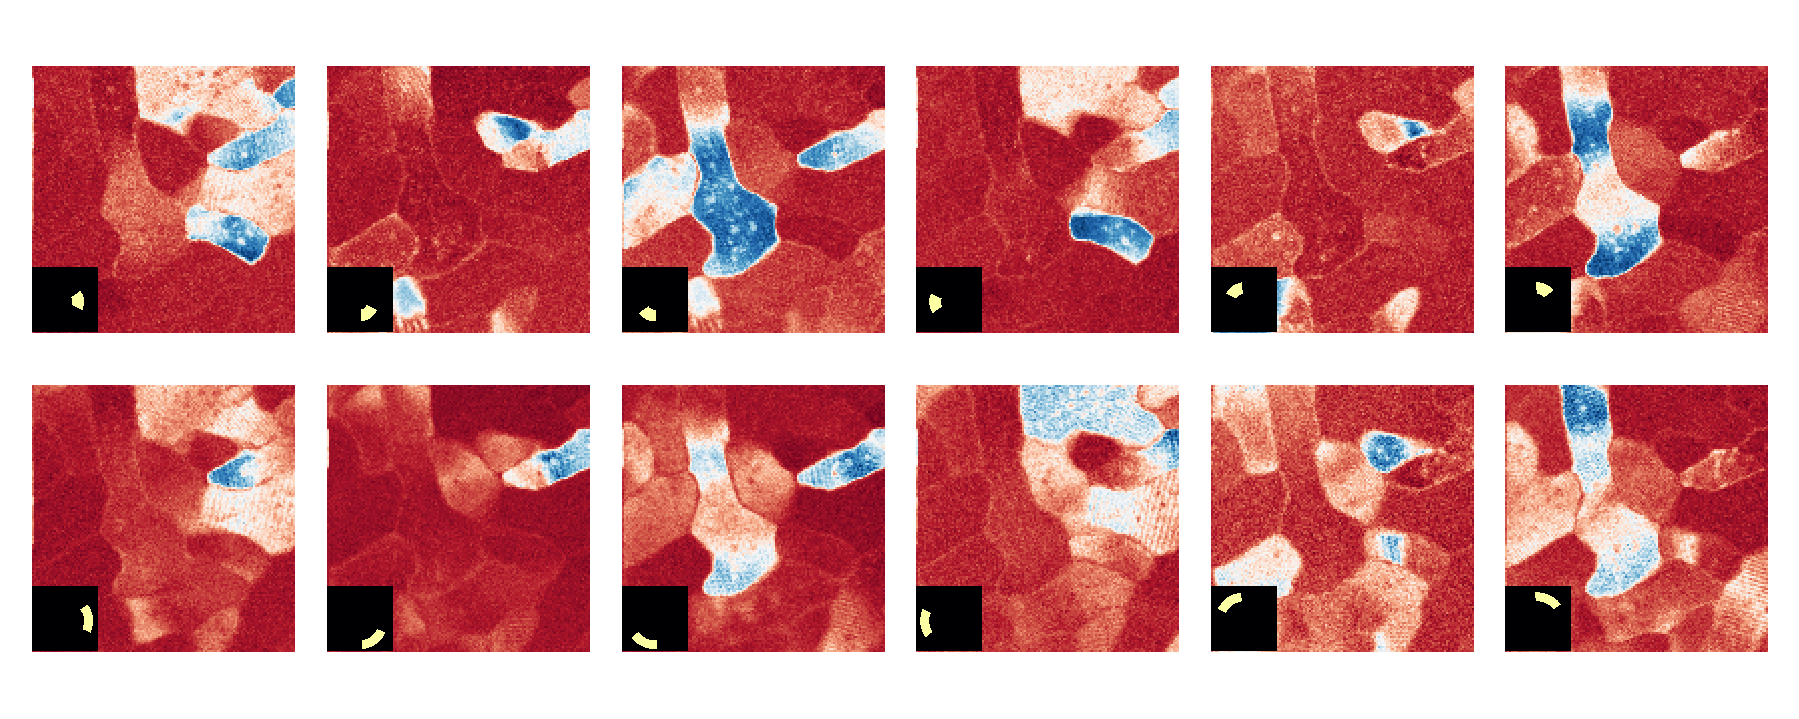

In [116]:
num=np.linspace(0,11,12)
fig, axes = plt.subplots(2,6, figsize=(10,4))
for ax, numbers in zip(axes.flatten(), num):
    ax.imshow(np.sqrt(color_maps[int(numbers)]), cmap=plt.cm.RdBu)
    ins = ax.inset_axes([0,0,0.25,0.25])
    ins.imshow(masks_12[int(numbers)], cmap=plt.cm.inferno)
    ax.axis('off')
    ins.axis('off')
plt.tight_layout()
plt.show()